In [17]:
import os
import glob
import re
import json
import yaml
import pandas as pd
pd.set_option('max_rows', 15)
import seaborn as sns
import numpy as np

from contrastive.utils.models_database import get_subdirs, get_path2logs, get_loss, post_process_bdd_models

In [2]:
paths = glob.glob("/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/pretrained_UKB/ACCpatterns/same_side/16-36-40_0" + "/*_results")
path = paths[0]
print(path)

#regex = "/(?<=/).*?(?=_results)"
regex = r"[^/]*_results"

matches = re.findall(regex, path)
for match in matches:
    print(match)

/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/pretrained_UKB/ACCpatterns/same_side/16-36-40_0/cingulate_ACCpatterns_results
cingulate_ACCpatterns_results


In [3]:
def get_test_dataset(dir_path):
    regex = r"[^/]*_results"
    matches = re.findall(regex, path)
    match = matches[0]
    return match[:-8]

get_test_dataset(path)

'cingulate_ACCpatterns'

In [4]:
def process_supervised_model(model_path, verbose=False):
    # generate a dictionnary with the model's parameters and performances
    model_dict = {}
    model_dict['model_path'] = model_path

    # read performances
    results_dirs = glob.glob(model_path + "/*_results")
    for results_dir in results_dirs:
        dataset_name = get_test_dataset(results_dir)
        with open(results_dir + "/test_results.json", 'r') as file:
            values = json.load(file)
            #decomposed_values = {f'{dataset_name}_test_auc': values['test_auc']}
            decomposed_values = {'test_auc': values['test_auc']}
            if 'test_intra_auc' in values.keys(): 
                decomposed_values['test_intra_auc'] = values['test_intra_auc']
            model_dict.update(decomposed_values)
        with open(results_dir + "/test_results_best_model.json", 'r') as file:
            values = json.load(file)
            #decomposed_values = {f'{dataset_name}_test_auc_best_model': values['test_auc']}
            decomposed_values = {'test_auc_best_model': values['test_auc']}
            if 'test_intra_auc' in values.keys(): 
                decomposed_values['test_intra_auc_best_model'] = values['test_intra_auc']
            model_dict.update(decomposed_values)
    
    # read parameters
    with open(model_path+'/partial_config.yaml', 'r') as file2:
        partial_config = yaml.load(file2, Loader=yaml.FullLoader)
        model_dict.update(partial_config)
    
    # compute losses if necessary
    log_path = get_path2logs(model_path)
    if not os.path.exists(os.path.join(log_path, "final_losses.json")):
        if verbose:
            print(f"Get the losses for {model_path}.")
        get_loss(model_path, save=True, verbose=verbose)
    
    # get the final losses
    with open(os.path.join(log_path, "final_losses.json"), 'r') as file3:
        losses = json.load(file3)
        model_dict.update(losses)

    return model_dict

In [5]:
process_supervised_model("/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/pretrained_UKB/ACCpatterns/same_side/16-36-40_0")

{'model_path': '/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/pretrained_UKB/ACCpatterns/same_side/16-36-40_0',
 'test_auc': 0.7710233029381965,
 'test_auc_best_model': 0.7669706180344478,
 'backbone_name': 'convnet',
 'batch_size': 16,
 'checkerboard_size': 4,
 'dataset_name': 'cingulate_ACCpatterns',
 'depth_decoder': 3,
 'drop_rate': 0.05,
 'early_stopping_patience': 25,
 'environment': 'not_brainvisa',
 'fill_value': 0,
 'foldlabel': True,
 'input_size': '(1, 20, 42, 38)',
 'keep_bottom': True,
 'lr': 0.001,
 'max_angle': 6,
 'max_epochs': 100,
 'mode': 'classifier',
 'model': 'SimCLR_supervised',
 'n_max': 1099,
 'nb_subjects': -1,
 'num_representation_features': 10,
 'partition': [0.9, 0.1],
 'percentage': 0,
 'pin_mem': True,
 'pretrained_model_path': '/neurospin/dico/jchavas/Runs/59_analysis_ukbiobank/Output/trained_on_ukbiobank/chosen_model/chosen_model/logs/default/version_0/checkpoints/epoch=250-step=297685.ckpt',
 'proportion_pure_contrastive': 0.0,
 'random_st

In [6]:
def generate_bdd_supervised_models(folders, bdd_models, visited,
                                   verbose=True, best_model=True):
    # depth first exploration of folders to treat all the models in it
    
    if verbose:
        print("Start", len(folders), len(bdd_models))

    while folders != []:
        # remove folders already treated
        folders = [folder for folder in folders if folder not in visited]
        
        # condition as folders can be emptied by the previous line
        if folders != []:
            dir_path = folders.pop()
            visited.append(dir_path)
            
            # checks if directory
            if os.path.isdir(dir_path):
                # check if directory associated to a model
                if os.path.exists(dir_path+'/.hydra/config.yaml'):
                    print("Treating", dir_path)
                    # check if values and parameters computed for the model
                    if glob.glob(dir_path + "/*_results") != []:
                        model_dict = process_supervised_model(dir_path)
                        bdd_models.append(model_dict)


                        if verbose:
                            print("End model", len(folders), len(bdd_models))

                    else:
                        print(f"Model has not been evaluated yet.")

                else:
                    print(f"{dir_path} not associated to a model. Continue")
                    new_dirs = get_subdirs(dir_path)
                    folders.extend(new_dirs)
                    # remove folders already treated
                    folders = [folder for folder in folders if folder not in visited]
                    if verbose:
                        print("End recursive", len(folders), len(bdd_models))
                    
                    generate_bdd_supervised_models(folders, bdd_models, visited,
                                        verbose=verbose, best_model=best_model)
            
            else:
                print(f"{dir_path} is a file. Continue.")
                if verbose:
                    print("End file", len(bdd_models))

In [14]:
folders = ["/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised"]
bdd = []
visited = []

generate_bdd_supervised_models(folders, bdd, visited)

bdd = pd.DataFrame(bdd)

bdd = post_process_bdd_models(bdd, hard_remove=['partition', 'patch_size', 'n_max'])

Start 1 0
/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised not associated to a model. Continue
End recursive 4 0
Start 4 0
/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/2023-04-25 not associated to a model. Continue
End recursive 4 0
Start 4 0
Treating /neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/2023-04-25/15-40-26
Model has not been evaluated yet.
/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/ACCpatterns not associated to a model. Continue
End recursive 4 0
Start 4 0
/neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/ACCpatterns/R not associated to a model. Continue
End recursive 21 0
Start 21 0
Treating /neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/ACCpatterns/R/10-35-58_3
End model 20 1
Treating /neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/ACCpatterns/R/10-04-09_0
End model 19 2
Treating /neurospin/dico/agaudin/Runs/09_new_repo/Output/supervised/ACCpatterns/R/09-46-31_2
End model 18 3
Treating /neu

In [15]:
bdd

,model_path,test_auc,test_auc_best_model,dataset_name,early_stopping_patience,foldlabel,input_size,lr,model,percentage,pretrained_model_path,proportion_pure_contrastive,sigma_labels,temperature_supervised,train_val_csv_file,with_labels,train_loss,val_loss,test_intra_auc,test_intra_auc_best_model
0,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.501520,0.536981,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,/neurospin/dico/data/deep_folding/current/data...,True,0.125940,3.954394,NaN,NaN
1,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.500507,0.648430,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,/neurospin/dico/data/deep_folding/current/data...,True,0.616289,2.337184,NaN,NaN
2,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.576494,0.602837,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,/neurospin/dico/data/deep_folding/current/data...,True,0.383075,2.446970,NaN,NaN
3,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.456940,0.600811,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,/neurospin/dico/data/deep_folding/current/data...,True,0.990833,1.377252,NaN,NaN
4,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.504559,0.506586,cingulate_ACCpatterns_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,/neurospin/dico/data/deep_folding/current/data...,True,1.384381,1.328602,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.478157,0.479589,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,NaN,True,1.305833,1.456876,0.687788,0.689804
45,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.485796,0.405825,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,NaN,True,1.204426,1.461519,0.644009,0.637385
46,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.467653,0.406063,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,NaN,True,1.325698,1.416836,0.685196,0.626152
47,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.472428,0.477680,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,NaN,True,1.332289,1.381910,0.687788,0.692684


# Analysis

In [16]:
schiz_bdd = bdd[bdd.dataset_name.str.contains("schiz")]
schiz_bdd

,model_path,test_auc,test_auc_best_model,dataset_name,early_stopping_patience,foldlabel,input_size,lr,model,percentage,pretrained_model_path,proportion_pure_contrastive,sigma_labels,temperature_supervised,train_val_csv_file,with_labels,train_loss,val_loss,test_intra_auc,test_intra_auc_best_model
33,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.470995,0.504655,cingulate_schiz_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,NaN,True,0.710044,2.399487,0.517569,0.509217
34,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.567200,0.450943,cingulate_schiz_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,NaN,True,0.979890,1.732319,0.507776,0.623560
35,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.484125,0.487228,cingulate_schiz_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,NaN,True,1.308859,1.639801,0.637385,0.591302
36,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.455717,0.472667,cingulate_schiz_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,NaN,True,1.317068,1.368463,0.659850,0.670219
37,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.443065,0.423251,cingulate_schiz_left,25,True,"(1, 20, 42, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,NaN,True,1.329581,1.391745,0.668491,0.682604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.478157,0.479589,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,NaN,True,1.305833,1.456876,0.687788,0.689804
45,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.485796,0.405825,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,NaN,True,1.204426,1.461519,0.644009,0.637385
46,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.467653,0.406063,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,NaN,True,1.325698,1.416836,0.685196,0.626152
47,/neurospin/dico/agaudin/Runs/09_new_repo/Outpu...,0.472428,0.477680,cingulate_schiz,25,True,"(1, 17, 40, 38)",0.0050,SimCLR_supervised,NaN,None,0.0,2.0,0.3,NaN,True,1.332289,1.381910,0.687788,0.692684


<AxesSubplot:xlabel='test_auc', ylabel='Count'>

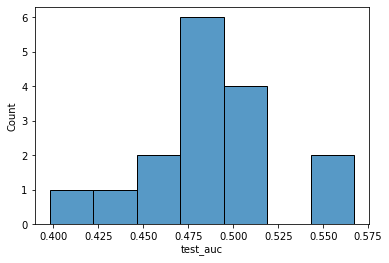

In [18]:
sns.histplot(schiz_bdd, x='test_auc')